In [1]:
%pylab inline
import numpy as np
import unittest
# On a import theano pour valider nos fonctions
import theano
import math

import gzip, pickle

import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


## Softmax

In [2]:
def softmax(v):
    e_x = np.exp(v - np.amax(v, axis=1))
    return e_x/e_x.sum(axis=1)

In [3]:
fake_array = np.matrix([0,1,2,3,4,5,6,7,8,9,10])

a = theano.shared(
    value=np.array(fake_array,
                   dtype=theano.config.floatX),
    name='a',
    borrow=True
)

assert(np.allclose(theano.tensor.nnet.nnet.softmax(a).eval(), softmax(fake_array)))

print("Softmax functional with arrays: ✓")

Softmax functional with arrays: ✓


In [4]:
fake_matrix = np.matrix([
    [0,1,2,3,4,5,6,7,8,9,10],
    [0,1,2,3,4,5,6,7,8,9,10],
    [0,1,2,3,4,5,6,7,8,9,10],
    [0,1,2,3,4,5,6,7,8,9,10],
    [0,1,2,3,4,5,6,7,8,9,10]
])

b = theano.shared(
    value=np.array(fake_matrix,
                     dtype=theano.config.floatX
                     ),
    name='b',
    borrow=True
)

assert(np.allclose(theano.tensor.nnet.nnet.softmax(b).eval(), softmax(fake_matrix)))

print("Softmax functional for matrices: ✓")

Softmax functional for matrices: ✓


In [5]:
def fprop(W1, W2, b1, b2, x, y=None):
    ha = np.dot(x, np.transpose(W1)) + b1
    hs = np.maximum(np.zeros(ha.shape), ha)

    oa = np.dot(hs, np.transpose(W2))  + b2
    os = softmax(oa)
    
    if y is None:
        loss = None
    else:
        y = y.astype(int)
        loss = -1*np.log(os[np.arange(len(os)),y.getA1()])

    return {
        'ha': ha,
        'hs': hs,
        'oa': oa,
        'os': os,
        'loss': loss
    }

In [6]:
def bprop(fprop, W1, W2, b1, b2, x, y, m):
    y = y.astype(int)
    grad_oa = fprop['os'] - np.eye(m)[y.getA1()]

    grad_b2 = np.sum(grad_oa, axis=0)
    #devrait être grad_w2 = np.dot(grad_oa,np.transpose(fprop['hs']))
    #grad_w2 = np.dot(np.transpose(grad_oa), fprop['hs']) #original eq de Mahmoud
    grad_w2 = np.transpose(np.dot(np.transpose(fprop['hs']),grad_oa))#doit ajouter np.transpose sur toute l'éq
    #devrait être grad_hs = np.dot(np.transpose(W2),grad_oa) MAIS NE FONCTIONNE PAS
    grad_hs = np.dot(grad_oa, W2) #original eq de Mahmoud
    #devrait être grad_ha = np.where(fprop['ha'])>=0,grad_hs,np.zeros(fprop['ha'].shape))
    #grad_ha = np.where(np.sign(fprop['ha'])+1,grad_hs,np.zeros(fprop['ha'].shape)) #original eq de Mahmoud
    grad_ha = np.where(fprop['ha']>=0,grad_hs,np.zeros(fprop['ha'].shape))
    grad_b1 = np.sum(grad_ha, axis=0)
    
    #devrait être grad_w1 = np.dot(grad_ha,np.transpose(x))
    #grad_w1 = np.dot(np.transpose(grad_ha),x) / x.shape[0] #original eq de Mahmoud
    grad_w1 = np.transpose(np.dot(np.transpose(x),grad_ha))#doit ajouter np.transpose sur toute l'éq
    return {
        'grad_w1': grad_w1,
        'grad_b1': grad_b1,
        'grad_ha': grad_ha,
        'grad_hs': grad_hs,
        'grad_w2': grad_w2,
        'grad_b2': grad_b2,
        'grad_oa': grad_oa
    }

In [7]:
np.random.seed(1234)

## Question 1

In [8]:
data = np.matrix([[12, 22, 0]])

x = data[:,:-1]
y = data[:,-1]

dh = 2
d = 2
m = 2
epsilon = 1e-5

# Initialisation des paramètres
W1 = np.random.uniform(
    -1 / math.sqrt(d), 
    1 / math.sqrt(d), 
    (dh, d))
b1 = np.zeros((1, dh))

W2 = np.random.uniform(
    -1 / math.sqrt(dh), 
    1 / math.sqrt(dh), 
    (m, dh))
b2 = np.zeros((1,m))

In [9]:
fprop_r = fprop(W1, W2, b1, b2, x, y)

In [10]:
bprop_r = bprop(fprop_r, W1, W2, b1, b2, x, y, m)

In [11]:
L = fprop_r['loss']

#### Verification du W2 gradient 

In [12]:
def check_grad_w2(L, W1, W2, b1, b2, x, y, epsilon):
    grad_diff = np.zeros(W2.shape)

    for i in list(range(W2.shape[0])):
        for j in list(range(W2.shape[1])):
            W2[i, j] += epsilon

            fprop_r_diff = fprop(W1, W2, b1, b2, x, y)

            L_prime = np.sum(fprop_r_diff['loss'])

            W2[i, j] -= epsilon

            grad_diff[i,j] = (L_prime - L) / epsilon
            
    return grad_diff

In [13]:
grad_w2_diff = check_grad_w2(L, W1, W2, b1, b2, x, y, epsilon)

print(grad_w2_diff)
print((bprop_r['grad_w2'] + epsilon) / (grad_w2_diff + epsilon))

[[ 0.         -7.79911931]
 [ 0.          7.79912105]]
[[ 1.          1.00000011]
 [ 1.          0.99999989]]


#### Verification du b2 gradient

In [14]:
def check_grad_b2(L, W1, W2, b1, b2, x, y, epsilon):    
    grad_diff = np.zeros(b2.shape)

    for i in list(range(b2.shape[1])):
        b2[0, i] += epsilon

        fprop_r_diff = fprop(W1, W2, b1, b2, x, y)

        L_prime = np.sum(fprop_r_diff['loss'])

        b2[0, i] -= epsilon

        grad_diff[0, i] = (L_prime -L) / epsilon
        
    return grad_diff

In [15]:
grad_b2_diff = check_grad_b2(L, W1, W2, b1, b2, x, y, epsilon)

print(grad_b2_diff)
print((bprop_r['grad_b2'] + epsilon) / (grad_b2_diff + epsilon))

[[-0.99714118  0.99714121]]
[[ 1.00000001  0.99999999]]


#### Verification du W1 gradient

In [16]:
def check_grad_w1(L, W1, W2, b1, b2, x, y, epsilon):   
    grad_diff = np.zeros(W1.shape)

    for i in list(range(W1.shape[0])):
        for j in list(range(W1.shape[1])):
            W1[i, j] += epsilon

            fprop_r_diff = fprop(W1, W2, b1, b2, x, y)

            L_prime = np.sum(fprop_r_diff['loss'])

            W1[i, j] -= epsilon

            grad_diff[i,j] = (L_prime - L) / epsilon

    return grad_diff

In [17]:
grad_w1_diff = check_grad_w1(L, W1, W2, b1, b2, x, y, epsilon)

print(grad_w1_diff)
print((bprop_r['grad_w1'] + epsilon) / (grad_w1_diff + epsilon))

[[  0.           0.        ]
 [  8.9564951   16.42024278]]
[[ 1.          1.        ]
 [ 0.99999987  0.99999976]]


#### Verification du b1 gradient

In [18]:
def check_grad_b1(L, W1, W2, b1, b2, x, y, epsilon):
    grad_diff = np.zeros(b1.shape)

    for i in list(range(b1.shape[1])):
        b1[0, i] += epsilon

        fprop_r_diff = fprop(W1, W2, b1, b2, x, y)

        L_prime = np.sum(fprop_r_diff['loss'])

        b1[0, i] -= epsilon

        grad_diff[0, i] = (L_prime -L) / epsilon
        
    return grad_diff

In [19]:
grad_b1_diff = check_grad_b1(L, W1, W2, b1, b2, x, y, epsilon)

print(grad_b1_diff)
print((bprop_r['grad_b1'] + epsilon) / (grad_b1_diff + epsilon))

[[ 0.         0.7463745]]
[[ 1.          0.99999999]]


## Question 2

In [20]:
class MLP:
    def __init__(self, d, m, dh, epsilon):
        self.total_grad = 0
        self.m = m
        self.epsilon = epsilon
        self.d = d
        self.dh = dh
        
        # Initialisation des paramètres
        self.W1 = np.random.uniform(
            -1 / math.sqrt(d), 
            1 / math.sqrt(d), 
            (dh, d))
        self.b1 = np.zeros((1, dh))

        self.W2 = np.random.uniform(
            -1 / math.sqrt(dh), 
            1 / math.sqrt(dh), 
            (m, dh))
        self.b2 = np.zeros((1, m))
        
    def verify_gradient(self, train, target, k):
        for i in list(range(k)):
            x = train[i]
            y = target[i]
            
            fprop_r = fprop(self.W1, self.W2, self.b1, self.b2, x, y)
            bprop_r = bprop(fprop_r, self.W1, self.W2, self.b1, self.b2, x, y, self.m)
            L = fprop_r['loss']

            grad_w2_diff = check_grad_w2(L, self.W1, self.W2, self.b1, self.b2, x, y, self.epsilon)
            grad_w1_diff = check_grad_w1(L, self.W1, self.W2, self.b1, self.b2, x, y, self.epsilon)
            grad_b2_diff = check_grad_b2(L, self.W1, self.W2, self.b1, self.b2, x, y, self.epsilon)
            grad_b1_diff = check_grad_b1(L, self.W1, self.W2, self.b1, self.b2, x, y, self.epsilon)

            grad_ratio_b1 = (bprop_r['grad_b1'] + self.epsilon) / (grad_b1_diff + self.epsilon)
            grad_ratio_w1 = (bprop_r['grad_w1'] + self.epsilon) / (grad_w1_diff + self.epsilon)
            grad_ratio_b2 = (bprop_r['grad_b2'] + self.epsilon) / (grad_b2_diff + self.epsilon)
            grad_ratio_w2 = (bprop_r['grad_w2'] + self.epsilon) / (grad_w2_diff + self.epsilon)

            def check_grad_ratio(ratio):
                return (ratio > 0.99).all() and (ratio < 1.01).all()

            if check_grad_ratio(grad_ratio_b2) and check_grad_ratio(grad_ratio_w2) and check_grad_ratio(grad_ratio_b1) and check_grad_ratio(grad_ratio_w1):
                print('Gradient verified for element {0} ✓'.format(i))
            else:
                print('Gradient error for element {0} X'.format(i))
    
    def batch_train(self, train, target, lamdas, learning_rate, k):
        self.total_grad = 0
        
        split_indices = list(range(k, train.shape[0], k))
        train_splits = np.split(train, split_indices)
        target_splits = np.split(target, split_indices)
        
        for i in list(range(0, len(train_splits) - 1, 1)):
            x = train_splits[i]
            y = target_splits[i]
            
            self.train(x, y, lamdas, learning_rate)
        
    def train(self, train, target, lamdas, learning_rate):
        for i in list(range(train.shape[0])):
            x = train[i]
            y = target[i]
            
            fprop_r = fprop(self.W1, self.W2, self.b1, self.b2, x, y)
            bprop_r = bprop(fprop_r, self.W1, self.W2, self.b1, self.b2, x, y, self.m)
            
            self.total_grad += np.sum(bprop_r['grad_oa'])
            
            regularization = lamdas[0,0]*self.W1.sum() + \
                lamdas[0,1]*np.square(self.W1).sum() + \
                lamdas[1,0]*self.W2.sum() + \
                lamdas[1,1]*np.square(self.W2).sum()
            
            self.W1 -= (learning_rate*bprop_r['grad_w1'] + regularization)
            self.W2 -= (learning_rate*bprop_r['grad_w2'] + regularization)
            
            self.b1 -= (learning_rate*bprop_r['grad_b1'] + regularization)
            self.b2 -= (learning_rate*bprop_r['grad_b2'] + regularization)

            
    def show_decision_regions(self, train_data):
        def combine(*seqin):
            '''returns a list of all combinations of argument sequences.
            for example: combine((1,2),(3,4)) returns
            [[1, 3], [1, 4], [2, 3], [2, 4]]'''
            def rloop(seqin,listout,comb):
                '''recursive looping function'''
                if seqin:                       # any more sequences to process?
                    for item in seqin[0]:
                        newcomb=comb+[item]     # add next item to current comb
                        # call rloop w/ rem seqs, newcomb
                        rloop(seqin[1:],listout,newcomb)
                else:                           # processing last sequence
                    listout.append(comb)        # comb finished, add to list
                    
            listout=[]                      # listout initialization
            rloop(seqin,listout,[])         # start recursive process
            return listout

        plt.figure()
        d1 = train_data[train_data[:, -1].getA1() > 0]
        d2 = train_data[train_data[:, -1].getA1() == 0]
        
        plt.scatter(d1[:, 0], d1[:, 1], c='b', label='classe 1')
        plt.scatter(d2[:, 0], d2[:, 1], c='g', label='classe 0')

        xgrid = np.linspace(np.min(train_data[:, 0]) - 0.5,
                        np.max(train_data[:, 0]) + 0.5,
                        100)
        ygrid = np.linspace(np.min(train_data[:, 1]) - 0.5,
                        np.max(train_data[:, 1]) + 0.5,
                        100)

        # calcule le produit cartesien entre deux listes
        # et met les resultats dans un array
        thegrid = np.array(combine(xgrid,ygrid))
        
        classesPred = []
        for x in thegrid:
            os = fprop(self.W1, self.W2, self.b1, self.b2, x)['os']
            classesPred.append(np.argmax(os,axis=1)+1)
        
        pylab.pcolormesh(xgrid, ygrid, np.array(classesPred).reshape((100, 100)).T, alpha=.3)
        plt.xlim(np.min(train_data[:, 0]) - 0.5, np.max(train_data[:, 0]) + 0.5)
        plt.ylim(np.min(train_data[:, 1]) - 0.5, np.max(train_data[:, 1]) + 0.5)
        plt.grid()
        plt.legend(loc='lower right')
        plt.title(title)
        plt.show()

In [21]:
dh = 2
d = 2
m = 2
k = 1
epsilon = 1e-5

nnet = MLP(d, m, dh, epsilon)

In [22]:
nnet.verify_gradient(x,y, k)

Gradient verified for element 0 ✓


## Questions 3 et 4

In [23]:
data = np.matrix([[64,67,0], 
                  [33, 56, 1], 
                  [13, 78, 0], 
                  [14, 18, 1]])

x = data[:, :-1]
y = data[:, -1]

In [24]:
dh = 2
d = 2
m = 2
k = 10
epsilon = 1e-5

nnet = MLP(d, m, dh, epsilon)

data = np.matrix(np.loadtxt(open('2moons.txt', 'r')))

train = data[:k, :-1]
target = data[:k, -1]

nnet.verify_gradient(train, target, k)

Gradient verified for element 0 ✓
Gradient verified for element 1 ✓
Gradient verified for element 2 ✓
Gradient verified for element 3 ✓
Gradient verified for element 4 ✓
Gradient verified for element 5 ✓
Gradient verified for element 6 ✓
Gradient verified for element 7 ✓
Gradient verified for element 8 ✓
Gradient verified for element 9 ✓


## Question 5

#### cas de base

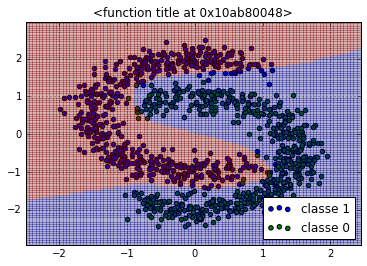

In [25]:
dh = 200
d = 2
m = 2
k = 10
epsilon = 1e-5

nnet = MLP(d, m, dh, epsilon)

train = data[:, :-1]
target = data[:, -1]
lamdas = np.matrix([[0.001, 0.0006],[0.004, 0.006]])
learning_rate = 0.21

nnet.train(train, target, lamdas, learning_rate)
nnet.show_decision_regions(data)

#### cas où on change les paramètres

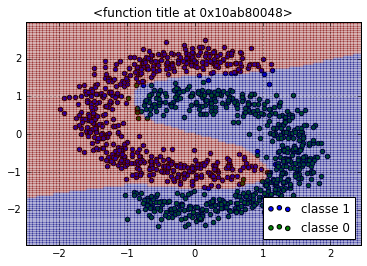

In [26]:
dh = 200
d = 2
m = 2
k = 10
epsilon = 1e-5

nnet2 = MLP(d, m, dh, epsilon)

train = data[:, :-1]
target = data[:, -1]
learning_rate = 0.21

nnet2.train(train, target, lamdas, learning_rate)
nnet2.show_decision_regions(data)

In [27]:
class MLPBatch(MLP):
    def train(self, train, target, lamdas, learning_rate, k):
        self.total_grad = 0
        split_indices = list(range(k, train.shape[0], k))
        train_splits = np.split(train, split_indices)
        target_splits = np.split(target, split_indices)
        
        for i in list(range(0, len(train_splits) - 1, 1)):
            x = train_splits[i]
            y = target_splits[i]
            
            fprop_r = fprop(self.W1, self.W2, self.b1, self.b2, x, y)
            bprop_r = bprop(fprop_r, self.W1, self.W2, self.b1, self.b2, x, y, self.m)
            
            self.total_grad += np.sum(bprop_r['grad_oa']/k)
            
            regularization = lamdas[0,0]*self.W1.sum() + \
                lamdas[0,1]*np.square(self.W1).sum() + \
                lamdas[1,0]*self.W2.sum() + \
                lamdas[1,1]*np.square(self.W2).sum()
            
            
            self.W1 -= ((learning_rate*bprop_r['grad_w1']/k) + regularization)
            self.W2 -= ((learning_rate*bprop_r['grad_w2']/k) + regularization)
            
            self.b1 -= (learning_rate*np.matrix(bprop_r['grad_b1']) + regularization)
            self.b2 -= (learning_rate*bprop_r['grad_b2'] + regularization)
        
    def verify_gradient(self, train, target, k):
        x = train[:k]
        y = target[:k]

        fprop_r = fprop(self.W1, self.W2, self.b1, self.b2, x, y)
        bprop_r = bprop(fprop_r, self.W1, self.W2, self.b1, self.b2, x, y, self.m)
        
        L = np.sum(fprop_r['loss'])

        grad_w2_diff = check_grad_w2(L, self.W1, self.W2, self.b1, self.b2, x, y, self.epsilon)
        grad_w1_diff = check_grad_w1(L, self.W1, self.W2, self.b1, self.b2, x, y, self.epsilon)
        grad_b2_diff = check_grad_b2(L, self.W1, self.W2, self.b1, self.b2, x, y, self.epsilon)
        grad_b1_diff = check_grad_b1(L, self.W1, self.W2, self.b1, self.b2, x, y, self.epsilon)

        grad_ratio_b1 = (bprop_r['grad_b1'] + self.epsilon) / (grad_b1_diff + self.epsilon)
        grad_ratio_w1 = (bprop_r['grad_w1'] + self.epsilon) / (grad_w1_diff + self.epsilon)
        grad_ratio_b2 = (bprop_r['grad_b2'] + self.epsilon) / (grad_b2_diff + self.epsilon)
        grad_ratio_w2 = (bprop_r['grad_w2'] + self.epsilon) / (grad_w2_diff + self.epsilon)
        
        def check_grad_ratio(ratio):
            return (ratio > 0.99).all() and (ratio < 1.01).all()

        if check_grad_ratio(grad_ratio_b2) and check_grad_ratio(grad_ratio_w2) and check_grad_ratio(grad_ratio_b1) and check_grad_ratio(grad_ratio_w1):
            print('Gradient verified for k={0} ✓'.format(k))
        else:
            print('Gradient error for k={0} X'.format(k))

## Question 6

Gradient verified for k=10 ✓


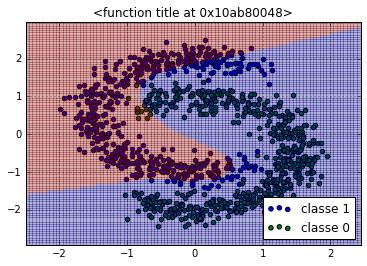

In [28]:
dh = 200
d = 2
m = 2
k = 10
epsilon = 1e-5

nnet_batch = MLPBatch(d, m, dh, epsilon)

train = data[:, :-1]
target = data[:, -1]
learning_rate = 0.21

nnet_batch.verify_gradient(train, target, k)
nnet_batch.train(train, target, lamdas, learning_rate, k)
nnet_batch.show_decision_regions(data)

## Question 7

Pour k=1 les gradients total so presque égales

In [29]:
dh = 200
d = 2
m = 2
k = 1
epsilon = 1e-5

nnet_batch_k_1 = MLPBatch(d, m, dh, epsilon)
nnet_k_1 = MLP(d, m, dh, epsilon)

nnet_batch_k_1.W1 = nnet_k_1.W1.copy()
nnet_batch_k_1.W2 = nnet_k_1.W2.copy()
nnet_batch_k_1.b1 = nnet_k_1.b1.copy()
nnet_batch_k_1.b2 = nnet_k_1.b2.copy()

nnet_batch_k_1.train(train, target, lamdas, learning_rate, k)
nnet_k_1.batch_train(train, target, lamdas, learning_rate, k)

print(nnet_batch_k_1.total_grad)
print(nnet_k_1.total_grad)

1.68916309675e-15
1.68916309675e-15


In [30]:
dh = 200
d = 2
m = 2
k = 2
epsilon = 1e-5

nnet_batch_k_10 = MLPBatch(d, m, dh, epsilon)
nnet_k_10 = MLP(d, m, dh, epsilon)

nnet_batch_k_10.W1 = nnet_k_10.W1.copy()
nnet_batch_k_10.W2 = nnet_k_10.W2.copy()
nnet_batch_k_10.b1 = nnet_k_10.b1.copy()
nnet_batch_k_10.b2 = nnet_k_10.b2.copy()

nnet_batch_k_10.train(train, target, lamdas, learning_rate, k)
nnet_k_10.batch_train(train, target, lamdas, learning_rate, k)

print(nnet_batch_k_10.total_grad)
print(nnet_k_10.total_grad)

7.75582561632e-16
-1.15700821408e-17
